In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
def warn(*args, **kwargs):
    pass # Suppress warnings generated by your code
warnings.warn = warn
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/content/Sample_datasets.csv')
df.head()

,obstime,tempr,ap,ws,wd,rh
0,11/1/2015 0:00,-12.52,973.92,29.30,86.38,43.13
1,11/1/2015 1:00,-11.88,973.54,26.00,87.63,44.22
2,11/1/2015 2:00,-10.60,973.14,24.80,86.27,43.35
3,11/1/2015 3:00,-9.46,972.51,23.96,87.77,43.95
4,11/1/2015 4:00,-7.80,971.80,20.90,72.77,44.03


In [6]:
df['Date'] = pd.to_datetime(df['obstime'])
df = df.set_index('Date')
df = df.drop(['obstime'],axis=1)
df = df.resample('D').mean()
df.head()

,tempr,ap,ws,wd,rh
Date,,,,,
2015-11-01,-6.08,966.88,16.92,98.49,48.32
2015-11-02,-3.98,964.94,18.34,64.72,76.83
2015-11-03,-2.88,980.19,9.94,100.01,60.47
2015-11-04,-7.33,975.11,9.92,98.63,49.23
2015-11-05,-6.58,970.41,6.58,109.39,54.94


<Axes: ylabel='Date'>

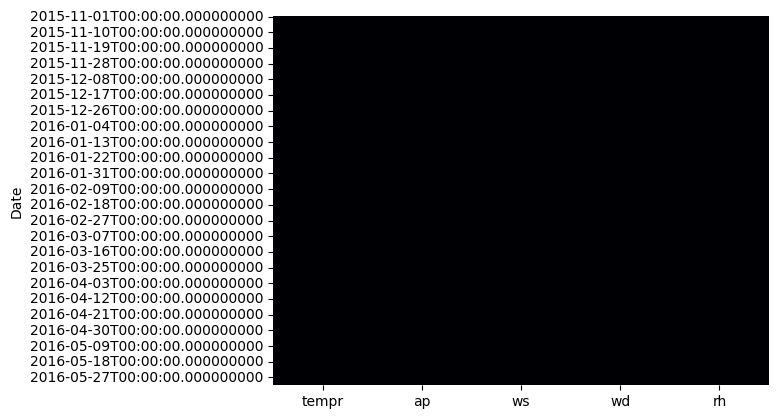

In [7]:
df = df.dropna()
sns.heatmap(df.isnull(),cmap = 'magma',cbar = False)


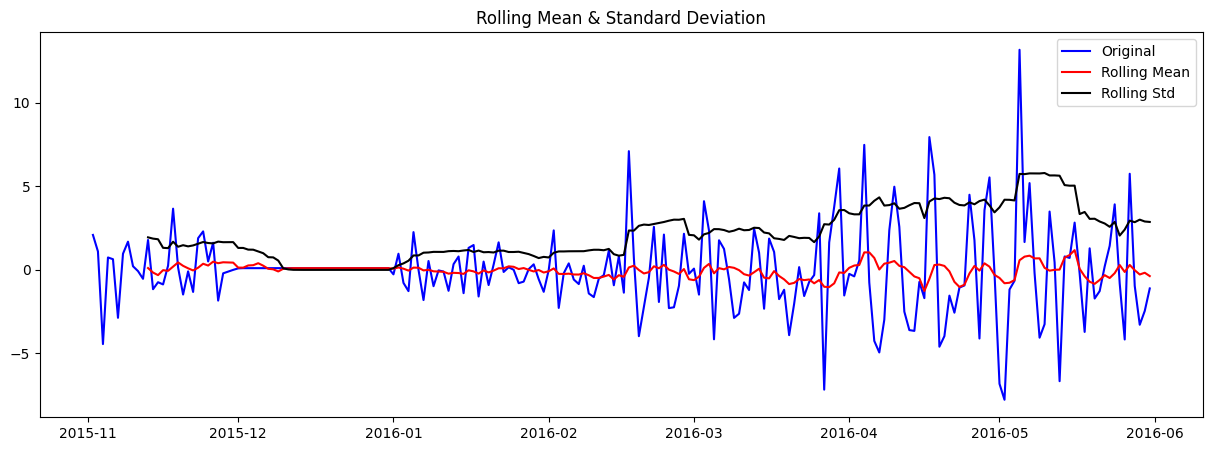

Results of Dickey-Fuller Test:
Test Statistic                 -5.16
p-value                         0.00
#Lags Used                     13.00
Number of Observations Used   197.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.88
Critical Value (10%)           -2.57
dtype: float64


In [40]:
# Select the 'tempr' column from the DataFrame before applying the test.
test_stationarity(df_diff['tempr'])

In [8]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

## ARIMA

- **ARIMA** model is a combination of 3 models :
    - **AR (p) : Auto Regressive**
    - **I (d) : Integrated**
    - **MA (q) : Moving Average**

- **(p,d,q)** is known as the order of the **ARIMA** model. Values of these parameters are based on the above mentioned models.  
    - **p** : Number of auto regressive terms.
    - **d** : Number of differencing orders required to make the time series stationary.
    - **q** : Number of lagged forecast errors in the prediction equation.

- Selection criteria for the order of **ARIMA** model :
    - **p** : Lag value where the **Partial Autocorrelation (PACF)** graph cuts off or drops to 0 for the 1st instance.
    - **d** : Number of times differencing is carried out to make the time series stationary.
    - **q** : Lag value where the **Autocorrelation (ACF)** graph crosses the upper confidence interval for the 1st instance.

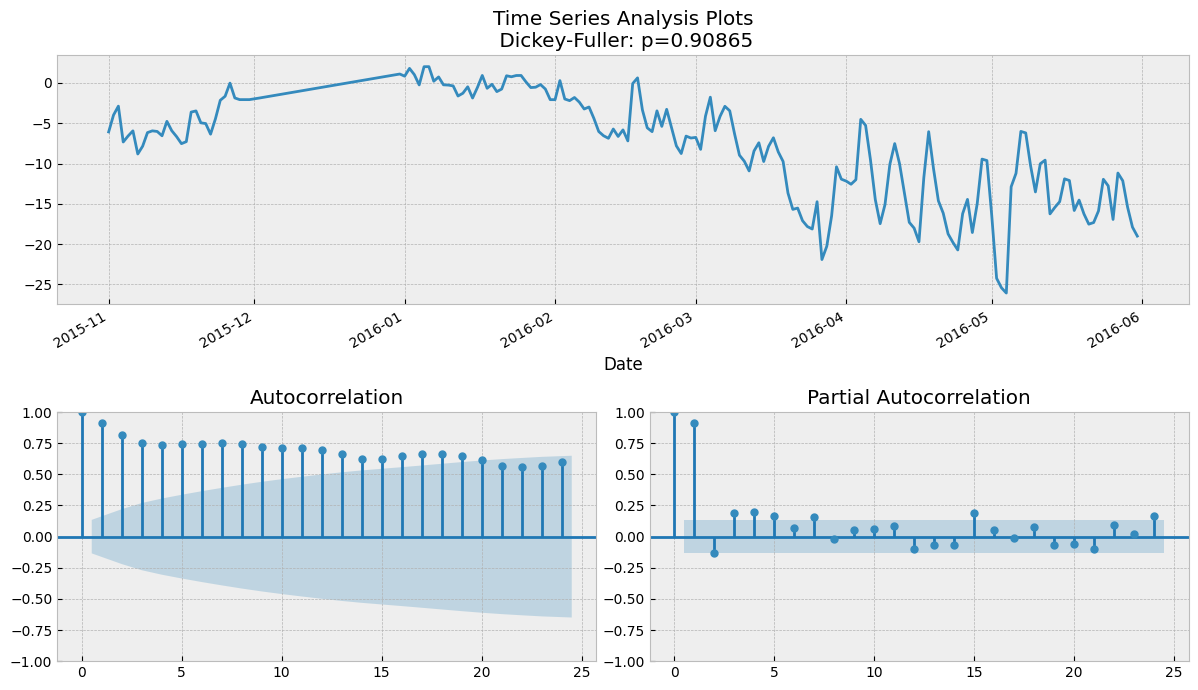

In [9]:
tsplot(df['tempr'])

In [10]:
def time_series_split(df, train_percent):
    train_size = int(len(df) * train_percent)
    predictor_train, target_train = pd.DataFrame(df.iloc[:train_size, 1:]), pd.DataFrame(df.iloc[:train_size, 0])
    predictor_test, target_test = pd.DataFrame(df.iloc[train_size:, 1:]), pd.DataFrame(df.iloc[train_size:, 0])
    return predictor_train, predictor_test, target_train, target_test

X_train, X_test, y_train, y_test = time_series_split(df, 0.9505)

In [11]:
y_train

,tempr
Date,
2015-11-01,-6.08
2015-11-02,-3.98
2015-11-03,-2.88
2015-11-04,-7.33
2015-11-05,-6.58
...,...
2016-05-16,-11.90
2016-05-17,-12.11
2016-05-18,-15.82


In [12]:
!pip install pmdarima
from pmdarima import auto_arima
arima_param = auto_arima(y_train, start_p=1, d=1, start_q=1, max_p=5, max_q=5, trace=True, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=931.860, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=944.953, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=944.140, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=942.543, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=943.033, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=911.531, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=935.278, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=912.765, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=912.829, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=916.769, Time=0.17 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=925.899, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=914.764, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=910.175, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=930.788, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=933.3

In [13]:
model = ARIMA(y_train,order = arima_param.get_params()['order'])
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  tempr   No. Observations:                  201
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -451.087
Date:                Sun, 25 Aug 2024   AIC                            910.175
Time:                        09:59:31   BIC                            923.368
Sample:                             0   HQIC                           915.514
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8412      0.065     13.013      0.000       0.714       0.968
ar.L2         -0.3463      0.062     -5.625      0.000      -0.467      -0.226
ma.L1         -0.8303      0.047    -17.789      0.0

In [14]:
size = int(len(df) - 30)
train, test = df['tempr'][0:size], df['tempr'][size:len(df)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):

    model = ARIMA(history, order=arima_param.get_params()['order'])
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = -18.261464, expected = -24.235833
predicted = -23.366329, expected = -25.412083
predicted = -21.774576, expected = -26.064630
predicted = -23.219502, expected = -12.880588
predicted = -9.328567, expected = -11.213333
predicted = -14.052330, expected = -6.015000
predicted = -8.200017, expected = -6.201667
predicted = -6.223041, expected = -10.264583
predicted = -13.399265, expected = -13.521250
predicted = -14.758207, expected = -10.027500
predicted = -9.619931, expected = -9.578750
predicted = -10.495568, expected = -16.246667
predicted = -17.450800, expected = -15.442917
predicted = -13.991943, expected = -14.727917
predicted = -13.812781, expected = -11.897500
predicted = -11.322211, expected = -12.106667
predicted = -12.643526, expected = -15.823810
predicted = -15.680487, expected = -14.532917
predicted = -13.555578, expected = -16.248750
predicted = -15.918280, expected = -17.520833
predicted = -16.672940, expected = -17.318333


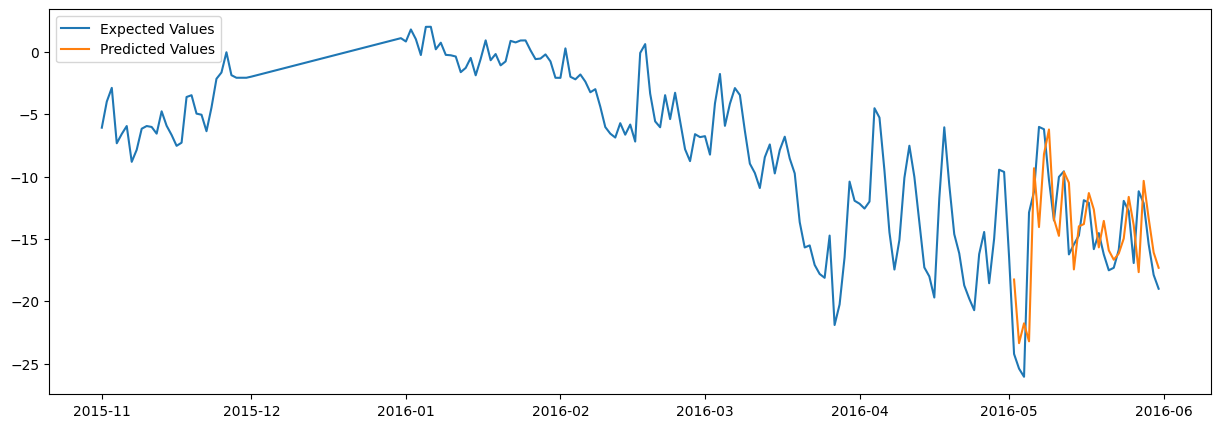

In [15]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['tempr'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values')
plt.legend(loc="upper left")
plt.show()

In [16]:
import plotly.graph_objects as go

predictions_series = pd.Series(predictions, index = test.index)

fig = go.Figure(data=[
    go.Scatter(x=df.index, y=df['tempr'], name='Expected Values'),
    go.Scatter(x=predictions_series.index, y=predictions_series, name='Predicted Values')
])

fig.update_layout(
    title='Expected vs Predicted Values',
    xaxis_title='Index',
    yaxis_title='Temperature',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
)

fig.show()

In [17]:
mse = mean_squared_error(test, predictions, squared=False)
rmse = mean_squared_error(test, predictions, squared=True)
mean = test.mean()
print("The error rates of the ARIMA forecasting are: \nMSE = %f \nRMSE = %f \nMean = %f" %(mse, rmse, mean))


The error rates of the ARIMA forecasting are: 
MSE = 3.719727 
RMSE = 13.836368 
Mean = -14.681496


### Out of Sample Forecasting

In [18]:
ARIMA_history_f = [x for x in train]
f1 = []

for t in range(48):

    model = ARIMA(ARIMA_history_f, order = arima_param.get_params()['order'])
    model_fit = model.fit()

    output = model_fit.forecast()[0]

    ARIMA_history_f.append(output)
    f1.append(output)



In [30]:
df_ext = pd.DataFrame({
    'Date':pd.date_range(df.index[-1],periods=len(f1)+1,freq='D')[1:],
    'tempr':f1
})

In [31]:
df_ext.tail()

,Date,tempr
43,2016-07-14,-17.07
44,2016-07-15,-17.84
45,2016-07-16,-18.93
46,2016-07-17,-19.45
47,2016-07-18,-19.45


In [32]:
import plotly.graph_objects as go

predictions_series = pd.Series(predictions, index = test.index)

fig = go.Figure(data=[
    go.Scatter(x=df.index, y=df['tempr'], name='Expected Values'),
    go.Scatter(x=predictions_series.index, y=predictions_series, name='Predicted Values'),
    go.Scatter(x=df_ext['Date'],y=df['tempr'], name='Future Forecast')
])

fig.update_layout(
    title='Expected vs Predicted Values',
    xaxis_title='Index',
    yaxis_title='Temperature',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
)

fig.show()

## <center>SARIMA</center>
### <center>Seasonal Auto Regressive Integrated Moving Average</center>

- **SARIMA** model is an extension of the ARIMA model that can handle the seasonal effects of the data.
- It has kind of 2 orders **(p,d,q) x (P,D,Q,M)**.
- **(p,d,q)** is the order that is similar to the order of the **ARIMA** model.
- **(P,D,Q,M)** is known as the Seasonal Order where **(P,D,Q)** are similar to the **(p,d,q)** of the ARIMA model.
- It's selection criteria is similar as well with an important condition i.e to handle the seasonality by differencing the data with the frequency of seasonal period or periodicity, **M** and check the **PACF** & **ACF** values at the **Mth** lag value.

In [23]:
sarimax_param = auto_arima(y_train, exogenous=X_train, m=7, start_p=0, d=1, start_q=0, start_P=0, D=1, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1, trace=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1014.641, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=995.951, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=1012.871, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=979.622, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=961.575, Time=1.12 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=925.977, Time=4.35 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=2.06 sec
 ARIMA(0,1,0)(3,1,1)[7]             : AIC=925.978, Time=2.97 sec
 ARIMA(2,1,0)(3,1,1)[7]             : AIC=918.696, Time=3.87 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=4.34 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=951.909, Time=1.07 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=970.279, Time=0.74 sec
 ARIMA(3,1,0)(3,1,1)[7]             : AIC=913.312, Time=3.65 sec
 ARIMA(3,1,0)(2,1,1)[7]             : AIC=917.014, Time=2

In [24]:
algorithm = SARIMAX(endog=y_train, exog=X_train, order=sarimax_param.get_params()["order"], seasonal_order=sarimax_param.get_params()["seasonal_order"])
model_fit = algorithm.fit(disp=False)
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             tempr   No. Observations:                  201
Model:             SARIMAX(2, 1, 1)x(3, 1, 1, 7)   Log Likelihood                -436.443
Date:                           Sun, 25 Aug 2024   AIC                            896.887
Time:                                   10:03:03   BIC                            936.039
Sample:                                        0   HQIC                           912.742
                                           - 201                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ap            -0.0473      0.030     -1.587      0.113      -0.106       0.011
ws            -0.0106      0.047     -0.224

In [25]:
size = int(len(df) - 30)
train, test = df['tempr'][0:size], df['tempr'][size:len(df)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):

    model = sm.tsa.statespace.SARIMAX(history,order = sarimax_param.get_params()["order"],seasonal_order = sarimax_param.get_params()["seasonal_order"])
    model_fit = model.fit()

    output = model_fit.forecast()

    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print('predicted = %f, expected = %f' % (yhat, obs))

	 SARIMA MODEL : In - Sample Forecasting 

predicted = -15.917564, expected = -24.235833
predicted = -23.350327, expected = -25.412083
predicted = -21.618514, expected = -26.064630
predicted = -22.833731, expected = -12.880588
predicted = -8.532866, expected = -11.213333
predicted = -13.133672, expected = -6.015000
predicted = -11.143737, expected = -6.201667
predicted = -10.635431, expected = -10.264583
predicted = -13.850125, expected = -13.521250
predicted = -15.390258, expected = -10.027500
predicted = -8.983851, expected = -9.578750
predicted = -11.408462, expected = -16.246667
predicted = -16.239194, expected = -15.442917
predicted = -12.222646, expected = -14.727917
predicted = -12.280712, expected = -11.897500
predicted = -12.438029, expected = -12.106667
predicted = -10.890137, expected = -15.823810
predicted = -18.928259, expected = -14.532917
predicted = -16.454438, expected = -16.248750
predicted = -16.839574, expected = -17.520833
predicted = -16.458079, expected = -17.318

In [28]:
mse = mean_squared_error(test, predictions, squared=False)
rmse = mean_squared_error(test, predictions, squared=True)
mean = test.mean()
print("The error rates of the SARIMA forecasting are: \nMSE = %f \nRMSE = %f \nMean = %f" %(mse, rmse, mean))

The error rates of the SARIMA forecasting are: 
MSE = 3.915039 
RMSE = 15.327533 
Mean = -14.681496


In [33]:

# Step 1: Auto ARIMA to determine the best SARIMAX parameters
sarimax_param = auto_arima(y_train, exogenous=X_train, m=7, start_p=0, d=1, start_q=0,
                           start_P=0, D=1, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1,
                           trace=True, seasonal=True)

# Step 2: Fitting the SARIMAX model with the optimal parameters found
model = SARIMAX(endog=y_train, exog=X_train,
                order=sarimax_param.get_params()["order"],
                seasonal_order=sarimax_param.get_params()["seasonal_order"])
model_fit = model.fit(disp=False)

# Print model summary for diagnostics
print(model_fit.summary())

# Step 3: Define train-test split
size = int(len(df) - 30)  # Split the data with last 30 observations as test data
train, test = df['tempr'][0:size], df['tempr'][size:len(df)]

# Step 4: In-sample forecasting (for training/testing evaluation)
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = SARIMAX(history, order=sarimax_param.get_params()["order"],
                    seasonal_order=sarimax_param.get_params()["seasonal_order"])
    model_fit = model.fit(disp=False)

    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print(f'predicted = {yhat:.6f}, expected = {obs:.6f}')

# Step 5: Out-of-sample forecasting (next 48 hours)
SARIMAX_history_f = [x for x in train]
f1 = []

for t in range(48):
    model = SARIMAX(SARIMAX_history_f,
                    order=sarimax_param.get_params()['order'],
                    seasonal_order=sarimax_param.get_params()['seasonal_order'])
    model_fit = model.fit(disp=False)

    output = model_fit.forecast()[0]
    SARIMAX_history_f.append(output)
    f1.append(output)

# Step 6: Creating DataFrame for future forecasts
df_ext = pd.DataFrame({
    'Date': pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=48, freq='D'),
    'tempr': f1
})

# Visualize the results
fig = go.Figure(data=[
    go.Scatter(x=df.index, y=df['tempr'], name='Expected Values'),  # Original data
    go.Scatter(x=test.index, y=predictions, name='Predicted Values (In-Sample)'),  # In-sample forecast
    go.Scatter(x=df_ext['Date'], y=df_ext['tempr'], name='Future Forecast (Out-of-Sample)')  # Out-of-sample forecast
])

fig.update_layout(
    title='Expected vs Predicted vs Future Forecasted Values',
    xaxis_title='Date',
    yaxis_title='Temperature',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
)

fig.show()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1014.641, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=995.951, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=1012.871, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=979.622, Time=0.40 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=961.575, Time=0.74 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=925.977, Time=1.56 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,0)(3,1,1)[7]             : AIC=925.978, Time=0.59 sec
 ARIMA(2,1,0)(3,1,1)[7]             : AIC=918.696, Time=1.02 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=0.57 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=951.909, Time=0.38 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=970.279, Time=0.15 sec
 ARIMA(3,1,0)(3,1,1)[7]             : AIC=913.312, Time=1.08 sec
 ARIMA(3,1,0)(2,1,1)[7]             : AIC=917.014, Time=0

In [34]:
mse = mean_squared_error(test, predictions, squared=False)
rmse = mean_squared_error(test, predictions, squared=True)
mean = test.mean()
print("The error rates of the SARIMA forecasting are: \nMSE = %f \nRMSE = %f \nMean = %f" %(mse, rmse, mean))

The error rates of the SARIMA forecasting are: 
MSE = 3.915039 
RMSE = 15.327533 
Mean = -14.681496
